In [1]:
import numpy as np
import pandas as pd

import time
from datetime import datetime

import gensim
import matplotlib.pyplot as plt

import en_nlp_utils
import model_evaluation_utils

In [2]:
# Define default source path
SRC_PATH = "src/"

start_time = datetime.now()
print("Text processing started at {}".format(start_time))

Text processing started at 2024-06-27 00:15:26.453093


In [3]:
# Load dataset
df_review = pd.read_csv(SRC_PATH + "en_hotel_review.csv")

In [4]:
# Check NULL values
en_nlp_utils.check_null(df_review, "df_review")

# Remove rows when "review_cleaned_v3" is NULL
df_review = df_review.dropna(subset=["review_cleaned_v3"]).reset_index(drop=True)

df_review:
source                      0
hotel_id                    0
hotel_name                  0
country                     0
group_name                  0
room_type                   0
stay_length                 0
stay_date                   0
review_score                0
review_score_category       0
sentiment                   0
review_date                 0
review_title                1
review                      0
review_cleaned_v1           0
review_cleaned_v2           0
review_cleaned_v3        1635
dtype: int64
Total rows in df_review: 39602 



## 1) Applying Stratified Sampling

In [5]:
# Function for stratified sampling
def stratified_sample(df, stratify_col, frac):
    return df.groupby(stratify_col, group_keys=False).apply(lambda x: x.sample(frac=frac))

# Convert "stay_date" and "review_date" columns as datetime data type
df_review["stay_date"] = pd.to_datetime(df_review["stay_date"], format="%d/%m/%Y")

# Stratified sampling based on year and sentiment
frac = 0.20  # Sampling ratio
sampled_2022 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2022], "sentiment", frac)
sampled_2023 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2023], "sentiment", frac)
sampled_2024 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2024], "sentiment", frac)

# Merge the sampled data
sampled_data = pd.concat([sampled_2022, sampled_2023, sampled_2024])

In [6]:
# Count number of reviews based on year and sentiment
sampled_sentiment_count = sampled_data.groupby([sampled_data["sentiment"], sampled_data["stay_date"].dt.year]).size().reset_index(name="count")
sampled_sentiment_count2 = sampled_sentiment_count.pivot_table(index="stay_date", columns="sentiment", values="count", 
                                               aggfunc="sum", margins=True, margins_name="Total")
sampled_sentiment_count2.columns.name = None
sampled_sentiment_count2

,negative,positive,Total
stay_date,,,
2022,330,1049,1379
2023,1045,4045,5090
2024,215,909,1124
Total,1590,6003,7593


## 2) Topic Modeling

### a) Helper functions

In [7]:
# Function to generate bow corpus
def generate_bow_corpus(df, target_text):
    
    documents = [en_nlp_utils.tokenize_sentence_to_words(cleaned_review) for cleaned_review in df[target_text]]
    
    bigram = gensim.models.Phrases(documents, min_count=20, threshold=20, delimiter="_") # higher threshold fewer phrases.
    bigram_model = gensim.models.phrases.Phraser(bigram)
    
    corpus_bigrams = [bigram_model[doc] for doc in documents]
    dictionary = gensim.corpora.Dictionary(corpus_bigrams)
    dictionary.filter_extremes(no_below=20, no_above=0.6)
    bow_corpus = [dictionary.doc2bow(text) for text in corpus_bigrams]
    
    return bow_corpus, corpus_bigrams, dictionary


# Function to calculate all models' coherence scores
def topic_model_coherence_plot(df, df_name, target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT):
    
    overall_coherence_df = pd.DataFrame() # Store each model's coherence scores
    model_topic_info = [] # Store each model's topic information
    
    bow_corpus, corpus_bigrams, dictionary = generate_bow_corpus(df, target_text)
    model_count = 0
    
    for MODEL_NAME in MODEL_NAMES:
        models, coherence_scores = en_nlp_utils.topic_model_coherence_generator(model_name=MODEL_NAME,
                                                                                corpus=bow_corpus,
                                                                                texts=corpus_bigrams,
                                                                                dictionary=dictionary,
                                                                                start_topic_count=START_TOPIC_COUNT,
                                                                                end_topic_count=END_TOPIC_COUNT,
                                                                                step=1,
                                                                                cpus=-1,
                                                                                print_topics=True)

        coherence_df = pd.DataFrame({"Model Name": MODEL_NAME, 
                                     "Number of Topics": range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1), 
                                     "Coherence Score": np.round(coherence_scores, 6),
                                     "df_name": df_name})
        coherence_df.sort_values(by=["Coherence Score"], ascending=False)
        print(coherence_df)
        
        overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0)
        
        model_topics = []
        for model in models:
            num_topics = model.num_topics
            topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=10)] for n in range(num_topics)]
            
            # Determine the number of columns dynamically
            num_terms_per_topic = max(len(topic) for topic in topics)
            
            # Create a DataFrame for topics with dynamic columns and names
            topics_df = pd.DataFrame([[term if len(topic) > i else "" for i, (term, wt) in enumerate(topic)]
                                      for topic in topics],
                                     columns=[f"Term{i+1}" for i in range(num_terms_per_topic)],
                                     index=[f"Topic {t+1}" for t in range(num_topics)]).T
            
            model_topic_info.append({
                "Model Name": MODEL_NAME,
                "Number of Topics": num_topics,
                "Topics": topics_df.to_dict(orient="list"),  # Convert DataFrame to dictionary
                "df_name": df_name
            })
        
        x_ax = range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1)
        y_ax = coherence_scores
        plt.figure(num=model_count, figsize=(15, 12))
        plt.plot(x_ax, y_ax, c="r")
        plt.axhline(y=0.3, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.4, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.5, c="k", linestyle="--", linewidth=2)
        plt.rcParams["figure.facecolor"] = "white"
        xl = plt.xlabel("Number of Topics")
        yl = plt.ylabel("Coherence Score")

        model_count += 1

    plt.show()
    return overall_coherence_df, model_topic_info


# Function to print best model's topics
def print_best_model_topics(overall_coherence_best_df, model_topic_info_list):
    
    for index, row in overall_coherence_best_df.iterrows():
        model_name = row["Model Name"]
        num_topics = row["Number of Topics"]
        df_name = row["df_name"]
        
        print(f"\nDF NAME: {df_name}\nMODEL: {model_name} - NUMBER OF TOPICS: {num_topics}")
       
        # Find the corresponding model_topic_info
        for model_topic_info in model_topic_info_list:
            for model_info in model_topic_info:
                if (model_info["Model Name"] == model_name and
                    model_info["Number of Topics"] == num_topics and
                    model_info["df_name"] == df_name):
                    
                    topics = model_info["Topics"]
                    for topic_num, terms in topics.items():
                        print(f"\n{topic_num}: {', '.join(terms)}")
                        
                    print("\n----------\n")
                    break

### b) Topic Modeling

In [8]:
# Filter positive and negative reviews and save into different dataframe
df_pos = sampled_data[sampled_data["sentiment"] == "positive"].reset_index(drop=True)
df_neg = sampled_data[sampled_data["sentiment"] == "negative"].reset_index(drop=True)

In [9]:
MODEL_NAMES = ["LSI", "LDA"]
START_TOPIC_COUNT = 2
END_TOPIC_COUNT = 10

df_sets = [df_pos, df_neg]
df_names = ["df_pos", "df_neg"]


DF NAME: df_pos



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▏                                                                         | 1/9 [01:42<13:41, 102.64s/it]

Topic #1:
0.350*"great" + 0.190*"friendly" + 0.177*"station" + 0.171*"singapore" + 0.150*"food" + 0.142*"really" + 0.142*"breakfast" + 0.141*"helpful" + 0.134*"overall" + 0.132*"close" + 0.132*"bathroom" + 0.126*"pool" + 0.124*"service" + 0.122*"comfortable" + 0.120*"provide" + 0.119*"price" + 0.113*"restaurant" + 0.111*"shower" + 0.104*"water" + 0.101*"facility"

Topic #2:
-0.845*"great" + 0.112*"station" + 0.109*"water" + 0.106*"provide" + 0.088*"request" + 0.086*"bathroom" + 0.081*"use" + 0.080*"however" + 0.080*"change" + 0.075*"towel" + 0.073*"shower" + 0.070*"tell" + -0.069*"friendly" + 0.066*"toilet" + -0.066*"facility" + 0.065*"quite" + 0.064*"feel" + 0.064*"still" + 0.062*"first" + 0.062*"really"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▍                                                                | 2/9 [03:30<12:19, 105.65s/it]

Topic #1:
0.347*"great" + 0.191*"friendly" + 0.177*"station" + 0.172*"singapore" + 0.151*"food" + 0.143*"breakfast" + 0.142*"really" + 0.141*"helpful" + 0.135*"overall" + 0.133*"close" + 0.132*"bathroom" + 0.124*"pool" + 0.123*"comfortable" + 0.122*"service" + 0.121*"provide" + 0.120*"price" + 0.114*"restaurant" + 0.111*"shower" + 0.104*"water" + 0.102*"facility"

Topic #2:
-0.853*"great" + 0.127*"station" + 0.112*"provide" + 0.107*"water" + 0.083*"bathroom" + -0.079*"pool" + 0.074*"request" + 0.074*"quite" + 0.073*"change" + 0.073*"however" + 0.067*"toilet" + 0.067*"tell" + 0.067*"shower" + 0.066*"towel" + 0.066*"use" + 0.063*"still" + 0.062*"really" + -0.061*"facility" + 0.060*"first" + 0.058*"work"

Topic #3:
0.479*"station" + -0.207*"service" + 0.194*"singapore" + 0.174*"close" + 0.169*"friendly" + -0.166*"pool" + -0.150*"really" + -0.142*"feel" + 0.142*"bus" + 0.138*"restaurant" + 0.138*"helpful" + -0.136*"bathroom" + -0.134*"shower" + 0.132*"convenient" + -0.130*"use" + 0.122*"fo

 33%|███████████████████████████▋                                                       | 3/9 [05:21<10:49, 108.18s/it]

Topic #1:
0.347*"great" + 0.190*"friendly" + 0.178*"station" + 0.170*"singapore" + 0.152*"food" + 0.143*"breakfast" + 0.142*"really" + 0.140*"helpful" + 0.135*"overall" + 0.132*"close" + 0.131*"bathroom" + 0.124*"pool" + 0.123*"service" + 0.122*"comfortable" + 0.120*"provide" + 0.120*"price" + 0.114*"restaurant" + 0.111*"shower" + 0.104*"water" + 0.102*"facility"

Topic #2:
-0.858*"great" + 0.112*"provide" + 0.103*"station" + 0.100*"water" + 0.078*"request" + 0.077*"bathroom" + 0.076*"however" + -0.075*"pool" + 0.073*"quite" + 0.072*"change" + 0.069*"tell" + 0.067*"use" + 0.065*"really" + 0.065*"toilet" + 0.064*"towel" + 0.064*"shower" + 0.062*"still" + 0.061*"work" + -0.060*"facility" + 0.057*"first"

Topic #3:
0.458*"station" + 0.233*"singapore" + 0.205*"friendly" + -0.189*"service" + 0.163*"close" + -0.157*"pool" + 0.151*"helpful" + -0.150*"really" + -0.142*"bathroom" + -0.140*"shower" + 0.137*"bus" + 0.132*"convenient" + -0.130*"feel" + 0.128*"restaurant" + -0.127*"use" + -0.120*"g

 44%|████████████████████████████████████▉                                              | 4/9 [07:08<08:59, 107.82s/it]

Topic #1:
0.343*"great" + 0.191*"friendly" + 0.177*"station" + 0.170*"singapore" + 0.153*"food" + 0.143*"really" + 0.143*"breakfast" + 0.141*"helpful" + 0.135*"overall" + 0.133*"close" + 0.131*"bathroom" + 0.124*"pool" + 0.123*"service" + 0.122*"comfortable" + 0.121*"provide" + 0.120*"price" + 0.115*"restaurant" + 0.111*"shower" + 0.105*"water" + 0.101*"facility"

Topic #2:
-0.863*"great" + 0.115*"provide" + 0.102*"water" + 0.091*"station" + 0.077*"really" + 0.077*"bathroom" + 0.076*"request" + 0.074*"quite" + 0.073*"however" + 0.072*"change" + 0.071*"use" + 0.070*"shower" + -0.067*"pool" + 0.066*"toilet" + 0.066*"towel" + 0.060*"tell" + 0.059*"still" + 0.059*"work" + -0.059*"facility" + 0.055*"iron"

Topic #3:
0.444*"friendly" + 0.360*"station" + 0.264*"helpful" + 0.202*"singapore" + -0.199*"bathroom" + -0.199*"great" + -0.196*"shower" + 0.144*"restaurant" + -0.137*"water" + 0.134*"convenient" + -0.133*"toilet" + -0.130*"really" + -0.119*"want" + -0.114*"use" + 0.113*"close" + -0.112*

 56%|██████████████████████████████████████████████                                     | 5/9 [09:05<07:23, 110.83s/it]

Topic #1:
0.341*"great" + 0.192*"friendly" + 0.177*"station" + 0.170*"singapore" + 0.153*"food" + 0.143*"really" + 0.143*"breakfast" + 0.141*"helpful" + 0.135*"overall" + 0.133*"close" + 0.132*"bathroom" + 0.124*"pool" + 0.122*"service" + 0.122*"comfortable" + 0.121*"provide" + 0.119*"price" + 0.115*"restaurant" + 0.112*"shower" + 0.105*"water" + 0.101*"facility"

Topic #2:
-0.862*"great" + 0.113*"provide" + 0.110*"water" + 0.104*"station" + -0.089*"pool" + 0.084*"bathroom" + 0.077*"shower" + 0.076*"request" + 0.072*"really" + 0.071*"towel" + 0.069*"use" + 0.068*"toilet" + 0.068*"quite" + 0.066*"work" + 0.064*"however" + 0.060*"change" + -0.059*"facility" + 0.058*"still" + 0.054*"iron" + 0.054*"tell"

Topic #3:
0.420*"station" + 0.393*"friendly" + 0.243*"helpful" + -0.214*"bathroom" + -0.201*"shower" + 0.170*"singapore" + -0.170*"great" + 0.157*"restaurant" + -0.157*"toilet" + 0.139*"convenient" + -0.132*"water" + 0.122*"close" + -0.121*"want" + -0.119*"use" + 0.112*"bus" + -0.111*"rea

 67%|███████████████████████████████████████████████████████▎                           | 6/9 [11:00<05:37, 112.53s/it]

Topic #1:
0.341*"great" + 0.191*"friendly" + 0.178*"station" + 0.170*"singapore" + 0.152*"food" + 0.143*"breakfast" + 0.143*"really" + 0.141*"helpful" + 0.135*"overall" + 0.134*"close" + 0.132*"bathroom" + 0.124*"pool" + 0.123*"service" + 0.122*"comfortable" + 0.121*"provide" + 0.119*"price" + 0.115*"restaurant" + 0.112*"shower" + 0.105*"water" + 0.101*"facility"

Topic #2:
-0.861*"great" + 0.111*"station" + 0.110*"water" + 0.108*"provide" + -0.084*"pool" + 0.077*"really" + 0.076*"bathroom" + 0.076*"request" + 0.074*"shower" + 0.069*"quite" + 0.068*"towel" + 0.067*"work" + 0.067*"use" + 0.067*"toilet" + 0.062*"however" + 0.060*"change" + -0.058*"facility" + 0.058*"still" + 0.055*"iron" + 0.053*"tell"

Topic #3:
0.532*"station" + 0.236*"friendly" + -0.215*"bathroom" + -0.199*"shower" + 0.178*"singapore" + 0.176*"helpful" + 0.152*"close" + 0.150*"convenient" + -0.149*"toilet" + 0.145*"restaurant" + 0.139*"bus" + -0.123*"great" + -0.118*"use" + -0.117*"want" + -0.113*"water" + -0.111*"tel

 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [12:56<03:47, 113.55s/it]

Topic #1:
0.341*"great" + 0.192*"friendly" + 0.178*"station" + 0.170*"singapore" + 0.151*"food" + 0.143*"breakfast" + 0.142*"really" + 0.141*"helpful" + 0.135*"overall" + 0.134*"close" + 0.132*"bathroom" + 0.124*"pool" + 0.123*"service" + 0.122*"comfortable" + 0.121*"provide" + 0.120*"price" + 0.115*"restaurant" + 0.112*"shower" + 0.105*"water" + 0.102*"facility"

Topic #2:
-0.871*"great" + 0.112*"station" + 0.105*"water" + 0.103*"provide" + 0.079*"bathroom" + 0.078*"really" + 0.073*"shower" + 0.072*"request" + 0.070*"quite" + -0.067*"pool" + 0.066*"use" + 0.065*"towel" + 0.065*"work" + 0.063*"toilet" + 0.059*"however" + 0.056*"change" + 0.054*"still" + -0.053*"facility" + 0.051*"iron" + 0.051*"tell"

Topic #3:
0.413*"friendly" + 0.413*"station" + 0.269*"helpful" + -0.225*"bathroom" + -0.222*"shower" + -0.166*"great" + -0.160*"toilet" + 0.154*"singapore" + 0.151*"restaurant" + -0.144*"water" + 0.134*"convenient" + -0.122*"use" + -0.117*"want" + 0.113*"close" + 0.110*"bus" + -0.105*"rea

 89%|█████████████████████████████████████████████████████████████████████████▊         | 8/9 [14:58<01:56, 116.09s/it]

Topic #1:
0.341*"great" + 0.192*"friendly" + 0.179*"station" + 0.170*"singapore" + 0.152*"food" + 0.143*"breakfast" + 0.142*"really" + 0.141*"helpful" + 0.135*"overall" + 0.134*"close" + 0.132*"bathroom" + 0.124*"pool" + 0.122*"service" + 0.122*"comfortable" + 0.121*"provide" + 0.120*"price" + 0.116*"restaurant" + 0.112*"shower" + 0.105*"water" + 0.102*"facility"

Topic #2:
-0.873*"great" + 0.120*"station" + 0.105*"water" + 0.105*"provide" + 0.078*"bathroom" + 0.072*"really" + 0.072*"shower" + 0.071*"request" + 0.068*"quite" + -0.065*"pool" + 0.065*"use" + 0.064*"towel" + 0.062*"toilet" + 0.061*"work" + 0.057*"however" + 0.055*"change" + -0.053*"facility" + 0.051*"walk" + 0.051*"tell" + 0.051*"still"

Topic #3:
0.481*"station" + 0.323*"friendly" + 0.216*"helpful" + -0.208*"bathroom" + -0.206*"shower" + 0.165*"restaurant" + 0.161*"close" + -0.146*"toilet" + 0.143*"singapore" + 0.140*"convenient" + 0.136*"food" + -0.134*"really" + 0.130*"bus" + -0.128*"great" + -0.124*"use" + -0.114*"wan

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [16:58<00:00, 113.19s/it]

Topic #1:
0.341*"great" + 0.193*"friendly" + 0.178*"station" + 0.170*"singapore" + 0.152*"food" + 0.143*"breakfast" + 0.142*"really" + 0.141*"helpful" + 0.135*"overall" + 0.134*"close" + 0.132*"bathroom" + 0.123*"pool" + 0.123*"comfortable" + 0.122*"service" + 0.121*"provide" + 0.120*"price" + 0.116*"restaurant" + 0.112*"shower" + 0.105*"water" + 0.101*"facility"

Topic #2:
-0.874*"great" + 0.115*"station" + 0.104*"provide" + 0.100*"water" + 0.075*"bathroom" + 0.071*"really" + 0.071*"request" + 0.070*"shower" + 0.067*"quite" + -0.065*"pool" + 0.065*"use" + 0.064*"towel" + 0.062*"toilet" + 0.062*"work" + 0.058*"however" + 0.056*"change" + -0.052*"facility" + 0.051*"still" + 0.050*"tell" + 0.049*"walk"

Topic #3:
0.500*"station" + 0.309*"friendly" + 0.209*"helpful" + -0.201*"shower" + -0.194*"bathroom" + 0.177*"close" + 0.163*"restaurant" + 0.143*"food" + 0.141*"convenient" + -0.140*"toilet" + 0.134*"singapore" + 0.134*"bus" + -0.126*"really" + -0.123*"use" + -0.119*"great" + -0.109*"wan


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:06<00:48,  6.12s/it]

Topic #1:
0.013*"friendly" + 0.012*"food" + 0.012*"really" + 0.010*"great" + 0.009*"service" + 0.008*"singapore" + 0.007*"facility" + 0.007*"shower" + 0.007*"sleep" + 0.007*"provide" + 0.007*"station" + 0.007*"quite" + 0.006*"super" + 0.006*"locate" + 0.006*"thank" + 0.006*"view" + 0.006*"reception" + 0.006*"use" + 0.006*"smell" + 0.006*"much"

Topic #2:
0.030*"great" + 0.016*"station" + 0.015*"helpful" + 0.014*"friendly" + 0.013*"breakfast" + 0.011*"comfortable" + 0.011*"close" + 0.010*"everything" + 0.009*"singapore" + 0.009*"restaurant" + 0.009*"overall" + 0.008*"pool" + 0.008*"price" + 0.008*"excellent" + 0.008*"lot" + 0.008*"love" + 0.008*"bathroom" + 0.007*"recommend" + 0.007*"facility" + 0.007*"convenient"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:12<00:43,  6.21s/it]

Topic #1:
0.029*"great" + 0.015*"food" + 0.012*"station" + 0.012*"overall" + 0.011*"quite" + 0.010*"shower" + 0.010*"price" + 0.009*"lot" + 0.009*"facility" + 0.009*"provide" + 0.009*"breakfast" + 0.008*"water" + 0.008*"sleep" + 0.008*"ok" + 0.008*"restaurant" + 0.008*"value_money" + 0.007*"toilet" + 0.007*"convenient" + 0.007*"smell" + 0.006*"close"

Topic #2:
0.012*"service" + 0.012*"really" + 0.012*"friendly" + 0.012*"helpful" + 0.010*"bathroom" + 0.010*"comfortable" + 0.009*"great" + 0.009*"singapore" + 0.009*"price" + 0.008*"recommend" + 0.008*"facility" + 0.008*"close" + 0.007*"big" + 0.007*"station" + 0.007*"provide" + 0.006*"breakfast" + 0.006*"want" + 0.006*"feel" + 0.006*"overall" + 0.006*"next"

Topic #3:
0.026*"great" + 0.021*"friendly" + 0.017*"station" + 0.013*"helpful" + 0.012*"love" + 0.012*"everything" + 0.011*"singapore" + 0.011*"excellent" + 0.011*"close" + 0.011*"food" + 0.010*"pool" + 0.010*"comfortable" + 0.010*"restaurant" + 0.010*"convenient" + 0.009*"breakfast"

 33%|████████████████████████████                                                        | 3/9 [00:17<00:35,  5.90s/it]

Topic #1:
0.038*"great" + 0.019*"friendly" + 0.014*"service" + 0.014*"singapore" + 0.014*"price" + 0.009*"helpful" + 0.009*"smell" + 0.008*"look" + 0.008*"spacious" + 0.008*"facility" + 0.008*"station" + 0.008*"easy" + 0.008*"bathroom" + 0.007*"overall" + 0.007*"attraction" + 0.007*"convenient" + 0.007*"toilet" + 0.007*"chinatown" + 0.006*"comfortable" + 0.006*"breakfast"

Topic #2:
0.016*"helpful" + 0.015*"friendly" + 0.013*"great" + 0.013*"singapore" + 0.012*"overall" + 0.012*"really" + 0.010*"station" + 0.010*"close" + 0.009*"definitely" + 0.009*"value_money" + 0.009*"excellent" + 0.009*"facility" + 0.008*"enjoy" + 0.008*"breakfast" + 0.008*"everything" + 0.007*"recommend" + 0.007*"experience" + 0.007*"big" + 0.007*"super" + 0.007*"highly_recommend"

Topic #3:
0.024*"station" + 0.013*"food" + 0.012*"love" + 0.011*"shower" + 0.011*"convenient" + 0.011*"really" + 0.010*"great" + 0.010*"restaurant" + 0.009*"many" + 0.009*"close" + 0.009*"everything" + 0.009*"work" + 0.009*"sleep" + 0.0

 44%|█████████████████████████████████████▎                                              | 4/9 [00:23<00:28,  5.74s/it]

Topic #1:
0.018*"comfortable" + 0.017*"love" + 0.014*"convenient" + 0.012*"really" + 0.012*"pool" + 0.012*"food" + 0.010*"view" + 0.009*"helpful" + 0.009*"amazing" + 0.009*"friendly" + 0.009*"great" + 0.009*"enjoy" + 0.009*"restaurant" + 0.009*"thank" + 0.008*"feel" + 0.008*"station" + 0.007*"fantastic" + 0.007*"breakfast" + 0.007*"next" + 0.007*"everything"

Topic #2:
0.015*"shower" + 0.015*"quite" + 0.015*"bathroom" + 0.014*"toilet" + 0.014*"work" + 0.012*"sleep" + 0.012*"space" + 0.011*"really" + 0.010*"overall" + 0.009*"smell" + 0.009*"luggage" + 0.009*"noise" + 0.009*"look" + 0.008*"hear" + 0.008*"iron" + 0.008*"big" + 0.008*"restaurant" + 0.007*"use" + 0.007*"find" + 0.007*"everything"

Topic #3:
0.031*"friendly" + 0.026*"helpful" + 0.021*"great" + 0.013*"experience" + 0.012*"recommend" + 0.012*"singapore" + 0.012*"overall" + 0.010*"breakfast" + 0.009*"perfect" + 0.008*"really" + 0.008*"facility" + 0.007*"kind" + 0.007*"excellent" + 0.007*"service" + 0.007*"accommodation" + 0.007

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:29<00:24,  6.00s/it]

Topic #1:
0.026*"station" + 0.023*"close" + 0.021*"great" + 0.020*"chinatown" + 0.017*"singapore" + 0.013*"friendly" + 0.013*"convenient" + 0.012*"bus" + 0.012*"boris" + 0.011*"pool" + 0.011*"super" + 0.010*"restaurant" + 0.010*"love" + 0.010*"helpful" + 0.009*"airport" + 0.009*"easy" + 0.008*"amenity" + 0.008*"shop" + 0.008*"attraction" + 0.007*"food"

Topic #2:
0.018*"bathroom" + 0.018*"love" + 0.016*"shower" + 0.016*"toilet" + 0.013*"quite" + 0.011*"great" + 0.010*"really" + 0.010*"everything" + 0.009*"experience" + 0.009*"iron" + 0.008*"enjoy" + 0.008*"big" + 0.008*"pool" + 0.008*"recommend" + 0.007*"comfortable" + 0.007*"work" + 0.007*"towel" + 0.007*"smell" + 0.007*"use" + 0.007*"every"

Topic #3:
0.042*"great" + 0.031*"friendly" + 0.022*"helpful" + 0.022*"comfortable" + 0.018*"really" + 0.018*"singapore" + 0.016*"service" + 0.016*"station" + 0.015*"value_money" + 0.012*"breakfast" + 0.012*"excellent" + 0.011*"size" + 0.010*"facility" + 0.010*"thank" + 0.010*"highly_recommend" + 

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:35<00:17,  5.94s/it]

Topic #1:
0.036*"station" + 0.033*"excellent" + 0.028*"comfortable" + 0.022*"bus" + 0.021*"service" + 0.018*"food" + 0.016*"great" + 0.015*"locate" + 0.015*"breakfast" + 0.014*"fantastic" + 0.014*"shopping" + 0.012*"friendly" + 0.012*"walk_distance" + 0.011*"love" + 0.010*"attraction" + 0.010*"quite" + 0.009*"right" + 0.009*"facility" + 0.009*"definitely" + 0.008*"next"

Topic #2:
0.037*"great" + 0.017*"bathroom" + 0.015*"toilet" + 0.015*"friendly" + 0.014*"breakfast" + 0.011*"helpful" + 0.011*"shower" + 0.010*"budget" + 0.010*"comfortable" + 0.009*"big" + 0.008*"work" + 0.008*"price" + 0.008*"n" + 0.007*"smell" + 0.007*"provide" + 0.007*"overall" + 0.007*"really" + 0.007*"short" + 0.007*"sleep" + 0.006*"food"

Topic #3:
0.021*"friendly" + 0.015*"sleep" + 0.014*"hear" + 0.012*"noise" + 0.012*"helpful" + 0.012*"however" + 0.011*"sound" + 0.010*"rest" + 0.009*"front_desk" + 0.009*"request" + 0.008*"another" + 0.008*"definitely" + 0.008*"early" + 0.008*"change" + 0.008*"call" + 0.008*"tel

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:41<00:11,  5.89s/it]

Topic #1:
0.057*"great" + 0.017*"overall" + 0.016*"helpful" + 0.014*"experience" + 0.012*"friendly" + 0.011*"size" + 0.010*"breakfast" + 0.010*"early" + 0.010*"comfortable" + 0.008*"shower" + 0.007*"facility" + 0.007*"people" + 0.007*"sleep" + 0.007*"kind" + 0.007*"arrive" + 0.006*"bathroom" + 0.006*"look" + 0.006*"lobby" + 0.006*"morning" + 0.006*"allow"

Topic #2:
0.024*"bathroom" + 0.019*"great" + 0.015*"service" + 0.012*"toilet" + 0.012*"water" + 0.011*"ok" + 0.011*"provide" + 0.011*"shower" + 0.010*"super" + 0.009*"singapore" + 0.009*"breakfast" + 0.008*"two" + 0.008*"use" + 0.008*"big" + 0.008*"space" + 0.008*"price" + 0.007*"want" + 0.007*"enough" + 0.007*"leave" + 0.007*"size"

Topic #3:
0.012*"restaurant" + 0.011*"food" + 0.010*"shower" + 0.010*"free" + 0.010*"provide" + 0.010*"close" + 0.010*"friendly" + 0.009*"old" + 0.009*"breakfast" + 0.009*"great" + 0.009*"airport" + 0.009*"lot" + 0.009*"station" + 0.008*"singapore" + 0.008*"overall" + 0.008*"available" + 0.008*"service" 

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:47<00:05,  5.79s/it]

Topic #1:
0.029*"comfortable" + 0.027*"station" + 0.021*"helpful" + 0.021*"friendly" + 0.018*"great" + 0.016*"singapore" + 0.016*"love" + 0.013*"boris" + 0.013*"perfect" + 0.012*"close" + 0.012*"spacious" + 0.012*"service" + 0.011*"highly_recommend" + 0.011*"restaurant" + 0.010*"fantastic" + 0.008*"next" + 0.008*"locate" + 0.007*"overall" + 0.007*"unfordable" + 0.007*"right"

Topic #2:
0.022*"excellent" + 0.020*"service" + 0.017*"breakfast" + 0.016*"definitely" + 0.016*"pool" + 0.015*"great" + 0.015*"food" + 0.015*"big" + 0.014*"friendly" + 0.013*"recommend" + 0.013*"provide" + 0.011*"facility" + 0.010*"station" + 0.010*"quite" + 0.009*"walk" + 0.009*"love" + 0.008*"many" + 0.008*"bus" + 0.008*"quality" + 0.008*"quiet"

Topic #3:
0.021*"facility" + 0.019*"friendly" + 0.018*"ok" + 0.018*"great" + 0.017*"restaurant" + 0.015*"old" + 0.014*"shopping" + 0.013*"food" + 0.013*"city" + 0.012*"helpful" + 0.011*"many" + 0.011*"far" + 0.011*"smell" + 0.011*"cleanliness" + 0.011*"center" + 0.010*"

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:53<00:00,  5.91s/it]

Topic #1:
0.055*"great" + 0.022*"value_money" + 0.022*"food" + 0.019*"facility" + 0.018*"service" + 0.015*"perfect" + 0.015*"ok" + 0.014*"friendly" + 0.014*"everything" + 0.013*"really" + 0.012*"bus" + 0.011*"helpful" + 0.011*"breakfast" + 0.010*"amazing" + 0.010*"star" + 0.010*"every" + 0.010*"big" + 0.009*"station" + 0.009*"definitely" + 0.009*"feel"

Topic #2:
0.016*"shower" + 0.016*"overall" + 0.013*"view" + 0.013*"use" + 0.012*"sleep" + 0.011*"experience" + 0.011*"look" + 0.011*"bathroom" + 0.011*"smell" + 0.010*"pool" + 0.009*"provide" + 0.009*"quite" + 0.008*"really" + 0.008*"facility" + 0.008*"toilet" + 0.008*"price" + 0.007*"however" + 0.007*"breakfast" + 0.007*"spacious" + 0.007*"much"

Topic #3:
0.055*"friendly" + 0.030*"helpful" + 0.029*"everything" + 0.029*"great" + 0.024*"love" + 0.018*"breakfast" + 0.014*"pool" + 0.013*"facility" + 0.012*"old" + 0.012*"comfortable" + 0.011*"food" + 0.011*"view" + 0.010*"enjoy" + 0.010*"station" + 0.009*"excellent" + 0.008*"restaurant" + 

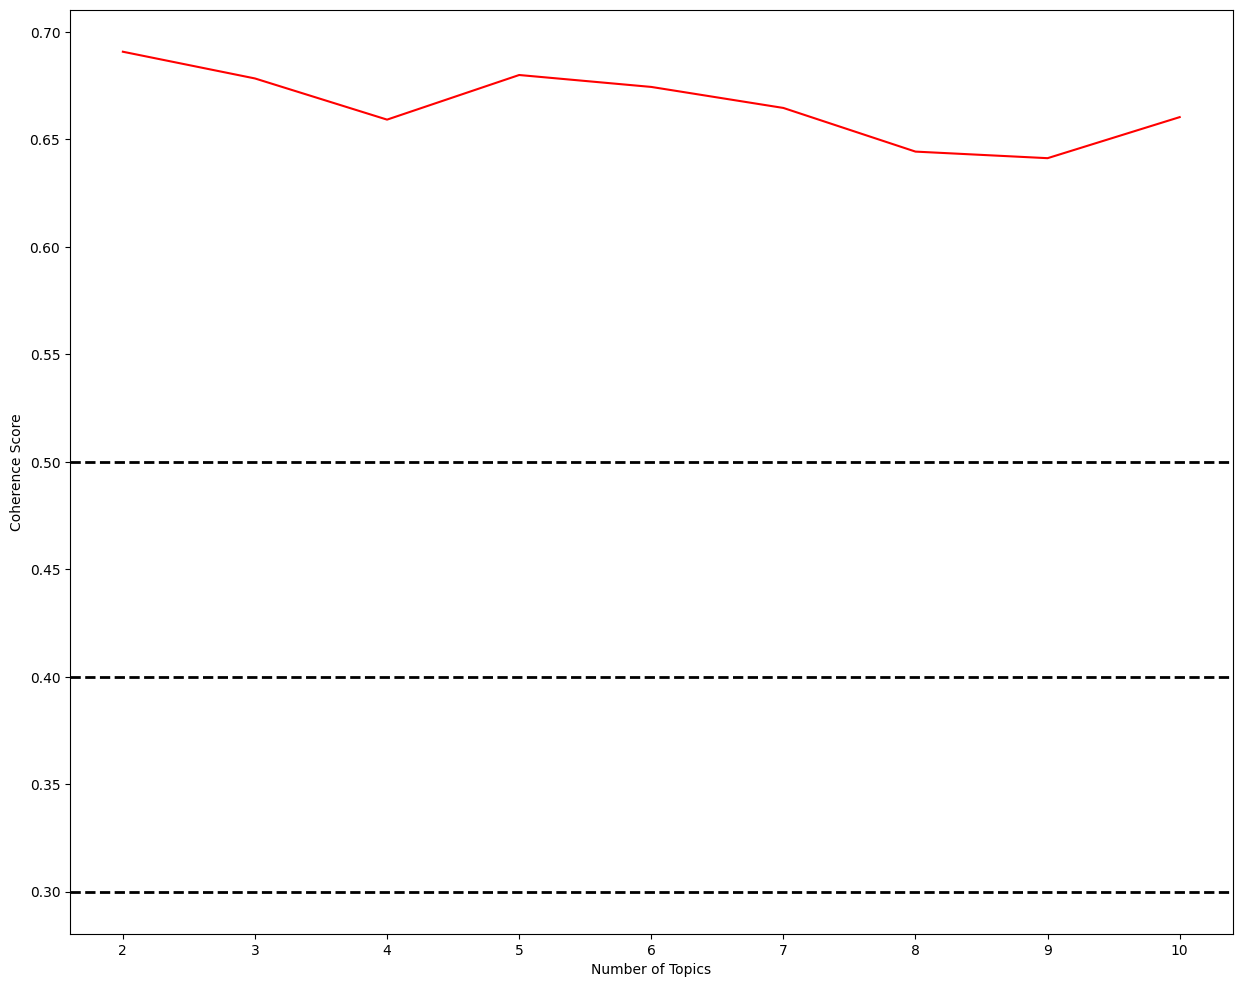

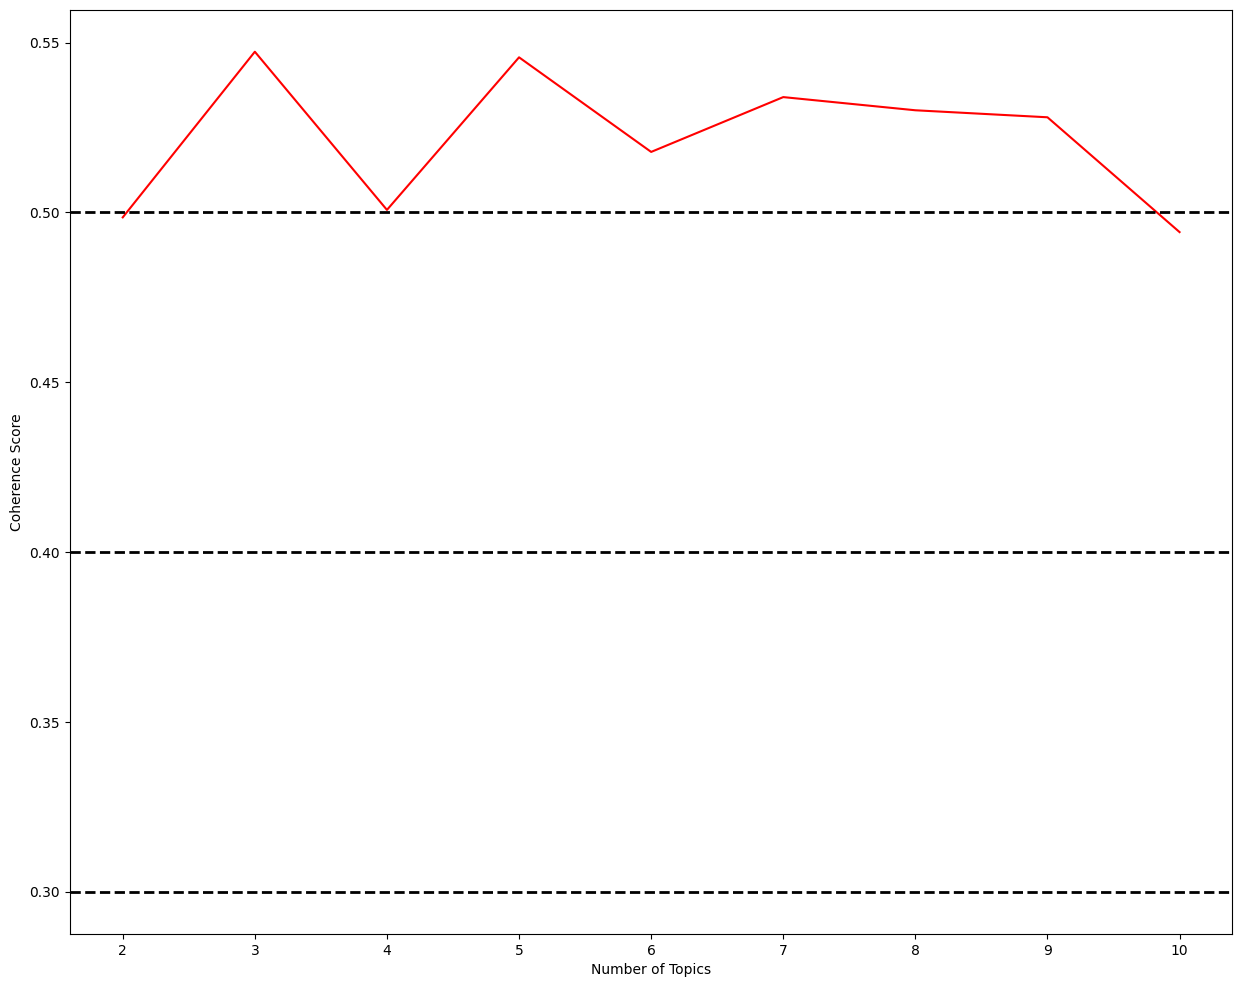


DF NAME: df_neg



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:18<02:29, 18.63s/it]

Topic #1:
0.220*"service" + 0.217*"breakfast" + 0.213*"toilet" + 0.194*"water" + 0.165*"shower" + 0.165*"dirty" + 0.153*"bathroom" + 0.147*"change" + 0.141*"work" + 0.135*"smell" + 0.134*"use" + 0.133*"reception" + 0.128*"look" + 0.123*"wait" + 0.123*"tell" + 0.123*"pay" + 0.116*"first" + 0.116*"price" + 0.113*"old" + 0.110*"really"

Topic #2:
0.680*"breakfast" + -0.237*"toilet" + -0.210*"smell" + -0.198*"dirty" + -0.194*"water" + 0.193*"service" + 0.188*"restaurant" + -0.183*"shower" + 0.157*"tell" + 0.124*"wait" + -0.111*"old" + -0.105*"bathroom" + 0.094*"food" + -0.080*"change" + -0.078*"use" + -0.075*"thing" + -0.074*"lock" + -0.073*"work" + -0.072*"sleep" + -0.072*"stain"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:37<02:10, 18.67s/it]

Topic #1:
0.220*"service" + 0.217*"breakfast" + 0.213*"toilet" + 0.194*"water" + 0.165*"shower" + 0.165*"dirty" + 0.153*"bathroom" + 0.147*"change" + 0.141*"work" + 0.135*"smell" + 0.134*"use" + 0.133*"reception" + 0.128*"look" + 0.123*"wait" + 0.123*"tell" + 0.123*"pay" + 0.116*"first" + 0.116*"price" + 0.113*"old" + 0.110*"really"

Topic #2:
0.680*"breakfast" + -0.237*"toilet" + -0.210*"smell" + -0.198*"dirty" + -0.194*"water" + 0.193*"service" + 0.188*"restaurant" + -0.183*"shower" + 0.157*"tell" + 0.124*"wait" + -0.111*"old" + -0.105*"bathroom" + 0.094*"food" + -0.080*"change" + -0.078*"use" + -0.075*"thing" + -0.074*"lock" + -0.073*"work" + -0.072*"sleep" + -0.072*"stain"

Topic #3:
-0.396*"service" + -0.396*"change" + -0.360*"dirty" + 0.284*"toilet" + 0.251*"water" + 0.235*"breakfast" + 0.194*"shower" + -0.185*"request" + -0.182*"housekeep" + -0.138*"look" + 0.125*"smell" + -0.125*"never" + -0.124*"stain" + 0.096*"old" + -0.092*"pillow" + 0.089*"thing" + -0.083*"cover" + 0.076*"p

 33%|████████████████████████████                                                        | 3/9 [00:55<01:51, 18.67s/it]

Topic #1:
0.220*"service" + 0.217*"breakfast" + 0.213*"toilet" + 0.194*"water" + 0.165*"shower" + 0.165*"dirty" + 0.153*"bathroom" + 0.147*"change" + 0.141*"work" + 0.135*"smell" + 0.134*"use" + 0.133*"reception" + 0.128*"look" + 0.123*"wait" + 0.123*"tell" + 0.123*"pay" + 0.116*"first" + 0.116*"price" + 0.113*"old" + 0.110*"really"

Topic #2:
0.680*"breakfast" + -0.237*"toilet" + -0.210*"smell" + -0.198*"dirty" + -0.194*"water" + 0.193*"service" + 0.188*"restaurant" + -0.183*"shower" + 0.157*"tell" + 0.124*"wait" + -0.111*"old" + -0.105*"bathroom" + 0.094*"food" + -0.080*"change" + -0.078*"use" + -0.075*"thing" + -0.074*"lock" + -0.073*"work" + -0.072*"sleep" + -0.072*"stain"

Topic #3:
-0.396*"service" + -0.396*"change" + -0.360*"dirty" + 0.284*"toilet" + 0.251*"water" + 0.235*"breakfast" + 0.194*"shower" + -0.185*"request" + -0.182*"housekeep" + -0.138*"look" + 0.125*"smell" + -0.125*"never" + -0.124*"stain" + 0.096*"old" + -0.092*"pillow" + 0.089*"thing" + -0.083*"cover" + 0.076*"p

 44%|█████████████████████████████████████▎                                              | 4/9 [01:14<01:32, 18.56s/it]

Topic #1:
0.220*"service" + 0.217*"breakfast" + 0.213*"toilet" + 0.194*"water" + 0.165*"shower" + 0.165*"dirty" + 0.153*"bathroom" + 0.147*"change" + 0.141*"work" + 0.135*"smell" + 0.134*"use" + 0.133*"reception" + 0.128*"look" + 0.123*"wait" + 0.123*"tell" + 0.123*"pay" + 0.116*"first" + 0.116*"price" + 0.113*"old" + 0.110*"really"

Topic #2:
0.680*"breakfast" + -0.237*"toilet" + -0.210*"smell" + -0.198*"dirty" + -0.194*"water" + 0.193*"service" + 0.188*"restaurant" + -0.183*"shower" + 0.157*"tell" + 0.124*"wait" + -0.111*"old" + -0.105*"bathroom" + 0.094*"food" + -0.080*"change" + -0.078*"use" + -0.075*"thing" + -0.074*"lock" + -0.073*"work" + -0.072*"sleep" + -0.072*"stain"

Topic #3:
0.396*"service" + 0.396*"change" + 0.360*"dirty" + -0.284*"toilet" + -0.251*"water" + -0.235*"breakfast" + -0.194*"shower" + 0.185*"request" + 0.182*"housekeep" + 0.138*"look" + -0.125*"smell" + 0.125*"never" + 0.124*"stain" + -0.096*"old" + 0.092*"pillow" + -0.089*"thing" + 0.083*"cover" + -0.076*"pri

 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:33<01:15, 18.77s/it]

Topic #1:
0.220*"service" + 0.217*"breakfast" + 0.213*"toilet" + 0.194*"water" + 0.165*"shower" + 0.165*"dirty" + 0.153*"bathroom" + 0.147*"change" + 0.141*"work" + 0.135*"smell" + 0.134*"use" + 0.133*"reception" + 0.128*"look" + 0.123*"wait" + 0.123*"tell" + 0.123*"pay" + 0.116*"first" + 0.116*"price" + 0.113*"old" + 0.110*"really"

Topic #2:
0.680*"breakfast" + -0.237*"toilet" + -0.210*"smell" + -0.198*"dirty" + -0.194*"water" + 0.193*"service" + 0.188*"restaurant" + -0.183*"shower" + 0.157*"tell" + 0.124*"wait" + -0.111*"old" + -0.105*"bathroom" + 0.094*"food" + -0.080*"change" + -0.078*"use" + -0.075*"thing" + -0.074*"lock" + -0.073*"work" + -0.072*"sleep" + -0.072*"stain"

Topic #3:
0.396*"service" + 0.396*"change" + 0.360*"dirty" + -0.284*"toilet" + -0.251*"water" + -0.235*"breakfast" + -0.194*"shower" + 0.185*"request" + 0.182*"housekeep" + 0.138*"look" + -0.125*"smell" + 0.125*"never" + 0.124*"stain" + -0.096*"old" + 0.092*"pillow" + -0.089*"thing" + 0.083*"cover" + -0.076*"pri

 67%|████████████████████████████████████████████████████████                            | 6/9 [01:52<00:56, 18.89s/it]

Topic #1:
0.220*"service" + 0.217*"breakfast" + 0.213*"toilet" + 0.194*"water" + 0.165*"shower" + 0.165*"dirty" + 0.153*"bathroom" + 0.147*"change" + 0.141*"work" + 0.135*"smell" + 0.134*"use" + 0.133*"reception" + 0.128*"look" + 0.123*"wait" + 0.123*"tell" + 0.123*"pay" + 0.116*"first" + 0.116*"price" + 0.113*"old" + 0.110*"really"

Topic #2:
0.680*"breakfast" + -0.237*"toilet" + -0.210*"smell" + -0.198*"dirty" + -0.194*"water" + 0.193*"service" + 0.188*"restaurant" + -0.183*"shower" + 0.157*"tell" + 0.124*"wait" + -0.111*"old" + -0.105*"bathroom" + 0.094*"food" + -0.080*"change" + -0.078*"use" + -0.075*"thing" + -0.074*"lock" + -0.073*"work" + -0.072*"sleep" + -0.072*"stain"

Topic #3:
0.396*"service" + 0.396*"change" + 0.360*"dirty" + -0.284*"toilet" + -0.251*"water" + -0.235*"breakfast" + -0.194*"shower" + 0.185*"request" + 0.182*"housekeep" + 0.138*"look" + -0.125*"smell" + 0.125*"never" + 0.124*"stain" + -0.096*"old" + 0.092*"pillow" + -0.089*"thing" + 0.083*"cover" + -0.076*"pri

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [02:11<00:37, 18.98s/it]

Topic #1:
0.220*"service" + 0.217*"breakfast" + 0.213*"toilet" + 0.194*"water" + 0.165*"shower" + 0.165*"dirty" + 0.153*"bathroom" + 0.147*"change" + 0.141*"work" + 0.135*"smell" + 0.134*"use" + 0.133*"reception" + 0.128*"look" + 0.123*"wait" + 0.123*"tell" + 0.123*"pay" + 0.116*"first" + 0.116*"price" + 0.113*"old" + 0.110*"really"

Topic #2:
0.680*"breakfast" + -0.237*"toilet" + -0.210*"smell" + -0.198*"dirty" + -0.194*"water" + 0.193*"service" + 0.188*"restaurant" + -0.183*"shower" + 0.157*"tell" + 0.124*"wait" + -0.111*"old" + -0.105*"bathroom" + 0.094*"food" + -0.080*"change" + -0.078*"use" + -0.075*"thing" + -0.074*"lock" + -0.073*"work" + -0.072*"sleep" + -0.072*"stain"

Topic #3:
-0.396*"service" + -0.396*"change" + -0.360*"dirty" + 0.284*"toilet" + 0.251*"water" + 0.235*"breakfast" + 0.194*"shower" + -0.185*"request" + -0.182*"housekeep" + -0.138*"look" + 0.125*"smell" + -0.125*"never" + -0.124*"stain" + 0.096*"old" + -0.092*"pillow" + 0.089*"thing" + -0.083*"cover" + 0.076*"p

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [02:31<00:19, 19.21s/it]

Topic #1:
0.220*"service" + 0.217*"breakfast" + 0.213*"toilet" + 0.194*"water" + 0.165*"shower" + 0.165*"dirty" + 0.153*"bathroom" + 0.147*"change" + 0.141*"work" + 0.135*"smell" + 0.134*"use" + 0.133*"reception" + 0.128*"look" + 0.123*"wait" + 0.123*"tell" + 0.123*"pay" + 0.116*"first" + 0.116*"price" + 0.113*"old" + 0.110*"really"

Topic #2:
0.680*"breakfast" + -0.237*"toilet" + -0.210*"smell" + -0.198*"dirty" + -0.194*"water" + 0.193*"service" + 0.188*"restaurant" + -0.183*"shower" + 0.157*"tell" + 0.124*"wait" + -0.111*"old" + -0.105*"bathroom" + 0.094*"food" + -0.080*"change" + -0.078*"use" + -0.075*"thing" + -0.074*"lock" + -0.073*"work" + -0.072*"sleep" + -0.072*"stain"

Topic #3:
-0.396*"service" + -0.396*"change" + -0.360*"dirty" + 0.284*"toilet" + 0.251*"water" + 0.235*"breakfast" + 0.194*"shower" + -0.185*"request" + -0.182*"housekeep" + -0.138*"look" + 0.125*"smell" + -0.125*"never" + -0.124*"stain" + 0.096*"old" + -0.092*"pillow" + 0.089*"thing" + -0.083*"cover" + 0.076*"p

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:51<00:00, 19.06s/it]


Topic #1:
0.220*"service" + 0.217*"breakfast" + 0.213*"toilet" + 0.194*"water" + 0.165*"shower" + 0.165*"dirty" + 0.153*"bathroom" + 0.147*"change" + 0.141*"work" + 0.135*"smell" + 0.134*"use" + 0.133*"reception" + 0.128*"look" + 0.123*"wait" + 0.123*"tell" + 0.123*"pay" + 0.116*"first" + 0.116*"price" + 0.113*"old" + 0.110*"really"

Topic #2:
0.680*"breakfast" + -0.237*"toilet" + -0.210*"smell" + -0.198*"dirty" + -0.194*"water" + 0.193*"service" + 0.188*"restaurant" + -0.183*"shower" + 0.157*"tell" + 0.124*"wait" + -0.111*"old" + -0.105*"bathroom" + 0.094*"food" + -0.080*"change" + -0.078*"use" + -0.075*"thing" + -0.074*"lock" + -0.073*"work" + -0.072*"sleep" + -0.072*"stain"

Topic #3:
-0.396*"service" + -0.396*"change" + -0.360*"dirty" + 0.284*"toilet" + 0.251*"water" + 0.235*"breakfast" + 0.194*"shower" + -0.185*"request" + -0.182*"housekeep" + -0.138*"look" + 0.125*"smell" + -0.125*"never" + -0.124*"stain" + 0.096*"old" + -0.092*"pillow" + 0.089*"thing" + -0.083*"cover" + 0.076*"p

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:04<00:38,  4.85s/it]

Topic #1:
0.020*"breakfast" + 0.019*"shower" + 0.017*"nothing" + 0.016*"bathroom" + 0.015*"work" + 0.015*"toilet" + 0.014*"service" + 0.012*"reception" + 0.011*"price" + 0.011*"change" + 0.011*"water" + 0.011*"recommend" + 0.011*"really" + 0.010*"wait" + 0.009*"walk" + 0.009*"sleep" + 0.008*"dirty" + 0.008*"use" + 0.008*"first" + 0.008*"pay"

Topic #2:
0.026*"smell" + 0.016*"dirty" + 0.015*"water" + 0.015*"old" + 0.014*"toilet" + 0.013*"service" + 0.013*"little" + 0.012*"breakfast" + 0.012*"price" + 0.011*"food" + 0.011*"bathroom" + 0.010*"use" + 0.010*"pay" + 0.010*"pool" + 0.010*"look" + 0.009*"sleep" + 0.009*"noise" + 0.009*"expensive" + 0.008*"work" + 0.008*"nothing"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:09<00:31,  4.47s/it]

Topic #1:
0.021*"toilet" + 0.020*"bathroom" + 0.017*"work" + 0.014*"smell" + 0.014*"shower" + 0.013*"breakfast" + 0.012*"change" + 0.012*"wait" + 0.011*"people" + 0.011*"experience" + 0.011*"mind" + 0.010*"open" + 0.010*"expensive" + 0.010*"late" + 0.009*"walk" + 0.009*"pay" + 0.009*"feel" + 0.009*"pool" + 0.009*"friendly" + 0.009*"service"

Topic #2:
0.021*"price" + 0.016*"old" + 0.016*"shower" + 0.016*"toilet" + 0.015*"recommend" + 0.013*"food" + 0.012*"money" + 0.012*"really" + 0.012*"next" + 0.011*"sleep" + 0.011*"smell" + 0.011*"change" + 0.011*"wall" + 0.011*"use" + 0.011*"thing" + 0.011*"nothing" + 0.010*"many" + 0.010*"quite" + 0.010*"dirty" + 0.010*"hear"

Topic #3:
0.028*"breakfast" + 0.027*"water" + 0.025*"service" + 0.024*"nothing" + 0.020*"dirty" + 0.017*"smell" + 0.012*"bathroom" + 0.012*"reception" + 0.011*"use" + 0.011*"price" + 0.011*"work" + 0.010*"much" + 0.010*"little" + 0.010*"pay" + 0.010*"look" + 0.009*"restaurant" + 0.009*"light" + 0.009*"star" + 0.009*"size" + 

 33%|████████████████████████████                                                        | 3/9 [00:12<00:25,  4.18s/it]

Topic #1:
0.024*"nothing" + 0.022*"look" + 0.019*"breakfast" + 0.019*"dirty" + 0.019*"work" + 0.016*"shower" + 0.016*"reception" + 0.016*"friendly" + 0.015*"expensive" + 0.015*"bathroom" + 0.012*"facility" + 0.012*"water" + 0.012*"old" + 0.012*"size" + 0.012*"wife" + 0.011*"use" + 0.011*"window" + 0.010*"recommend" + 0.010*"big" + 0.010*"price"

Topic #2:
0.041*"breakfast" + 0.032*"smell" + 0.028*"service" + 0.018*"nothing" + 0.018*"old" + 0.015*"toilet" + 0.014*"little" + 0.013*"price" + 0.012*"ok" + 0.012*"wait" + 0.011*"dirty" + 0.011*"feel" + 0.011*"singapore" + 0.010*"find" + 0.010*"tell" + 0.010*"restaurant" + 0.010*"work" + 0.010*"lift" + 0.010*"great" + 0.009*"star"

Topic #3:
0.030*"water" + 0.016*"toilet" + 0.015*"bathroom" + 0.014*"change" + 0.014*"service" + 0.013*"use" + 0.012*"work" + 0.012*"sleep" + 0.011*"want" + 0.010*"experience" + 0.010*"never" + 0.010*"dirty" + 0.009*"mind" + 0.009*"wait" + 0.009*"reception" + 0.009*"food" + 0.009*"money" + 0.009*"provide" + 0.009*"

 44%|█████████████████████████████████████▎                                              | 4/9 [00:16<00:20,  4.05s/it]

Topic #1:
0.029*"dirty" + 0.026*"smell" + 0.025*"work" + 0.024*"toilet" + 0.022*"little" + 0.022*"nothing" + 0.016*"feel" + 0.014*"pay" + 0.012*"wife" + 0.011*"pool" + 0.011*"breakfast" + 0.011*"hot" + 0.011*"first" + 0.010*"use" + 0.010*"shower" + 0.010*"never" + 0.010*"station" + 0.009*"friendly" + 0.009*"food" + 0.009*"want"

Topic #2:
0.031*"shower" + 0.027*"water" + 0.020*"nothing" + 0.020*"wait" + 0.019*"breakfast" + 0.015*"open" + 0.014*"bathroom" + 0.014*"toilet" + 0.013*"service" + 0.012*"reception" + 0.012*"tell" + 0.012*"work" + 0.012*"walk" + 0.011*"expensive" + 0.011*"super" + 0.011*"friendly" + 0.011*"poor" + 0.010*"lift" + 0.009*"price" + 0.009*"provide"

Topic #3:
0.019*"price" + 0.017*"service" + 0.017*"toilet" + 0.015*"reception" + 0.014*"sleep" + 0.013*"really" + 0.012*"smell" + 0.011*"many" + 0.011*"much" + 0.011*"size" + 0.011*"charge" + 0.010*"bar" + 0.010*"experience" + 0.010*"iron" + 0.010*"look" + 0.010*"bathroom" + 0.009*"pay" + 0.009*"window" + 0.009*"full" +

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:20<00:15,  3.93s/it]

Topic #1:
0.026*"bathroom" + 0.024*"old" + 0.022*"pool" + 0.017*"quite" + 0.017*"reception" + 0.016*"price" + 0.015*"water" + 0.015*"never" + 0.014*"work" + 0.013*"nothing" + 0.013*"thing" + 0.013*"though" + 0.011*"service" + 0.010*"shower" + 0.010*"dirty" + 0.010*"however" + 0.010*"date" + 0.010*"lock" + 0.010*"luggage" + 0.010*"expect"

Topic #2:
0.029*"work" + 0.029*"shower" + 0.024*"nothing" + 0.022*"really" + 0.018*"facility" + 0.018*"old" + 0.016*"smell" + 0.015*"great" + 0.014*"toilet" + 0.014*"iron" + 0.014*"sleep" + 0.013*"price" + 0.013*"water" + 0.013*"service" + 0.013*"people" + 0.013*"money" + 0.013*"expensive" + 0.012*"want" + 0.011*"find" + 0.011*"bathroom"

Topic #3:
0.022*"dirty" + 0.022*"water" + 0.018*"look" + 0.017*"recommend" + 0.016*"breakfast" + 0.016*"reception" + 0.016*"stain" + 0.014*"towel" + 0.014*"smell" + 0.014*"change" + 0.013*"cockroach" + 0.013*"really" + 0.012*"friendly" + 0.011*"work" + 0.011*"seem" + 0.011*"sheet" + 0.011*"wash" + 0.011*"bathroom" + 

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:24<00:11,  3.87s/it]

Topic #1:
0.026*"breakfast" + 0.024*"price" + 0.023*"water" + 0.017*"food" + 0.015*"pool" + 0.015*"toilet" + 0.015*"provide" + 0.014*"much" + 0.012*"service" + 0.012*"experience" + 0.012*"many" + 0.012*"ok" + 0.011*"shower" + 0.011*"leave" + 0.011*"early" + 0.010*"pay" + 0.010*"expensive" + 0.010*"first" + 0.010*"recommend" + 0.010*"old"

Topic #2:
0.025*"toilet" + 0.022*"nothing" + 0.017*"thing" + 0.015*"breakfast" + 0.015*"bathroom" + 0.015*"noise" + 0.015*"shower" + 0.014*"look" + 0.014*"open" + 0.014*"really" + 0.014*"restaurant" + 0.013*"service" + 0.012*"quite" + 0.012*"recommend" + 0.011*"morning" + 0.011*"next" + 0.011*"family" + 0.010*"light" + 0.010*"water" + 0.010*"price"

Topic #3:
0.023*"bathroom" + 0.023*"service" + 0.022*"really" + 0.019*"smell" + 0.017*"breakfast" + 0.015*"poor" + 0.014*"sleep" + 0.014*"lot" + 0.014*"tiny" + 0.013*"find" + 0.013*"water" + 0.012*"cockroach" + 0.012*"never" + 0.011*"price" + 0.011*"card" + 0.011*"money" + 0.010*"toilet" + 0.010*"window" +

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:27<00:07,  3.80s/it]

Topic #1:
0.038*"work" + 0.031*"water" + 0.022*"breakfast" + 0.020*"facility" + 0.018*"old" + 0.017*"change" + 0.017*"bathroom" + 0.016*"recommend" + 0.013*"late" + 0.012*"smell" + 0.012*"star" + 0.011*"toilet" + 0.011*"friendly" + 0.010*"singapore" + 0.010*"seem" + 0.010*"next" + 0.010*"feel" + 0.010*"poor" + 0.010*"cleanliness" + 0.009*"quite"

Topic #2:
0.035*"service" + 0.026*"smell" + 0.023*"wait" + 0.016*"first" + 0.016*"breakfast" + 0.014*"price" + 0.013*"really" + 0.013*"reception" + 0.013*"lift" + 0.011*"much" + 0.011*"window" + 0.011*"lobby" + 0.011*"tell" + 0.010*"bathroom" + 0.010*"walk" + 0.010*"call" + 0.010*"outside" + 0.010*"customer" + 0.009*"open" + 0.009*"still"

Topic #3:
0.022*"pool" + 0.021*"reception" + 0.021*"think" + 0.019*"see" + 0.019*"friendly" + 0.016*"breakfast" + 0.015*"smell" + 0.015*"enough" + 0.014*"cold" + 0.014*"card" + 0.013*"mind" + 0.012*"price" + 0.012*"really" + 0.012*"singapore" + 0.012*"experience" + 0.012*"issue" + 0.012*"rude" + 0.011*"charg

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:31<00:03,  3.80s/it]

Topic #1:
0.053*"nothing" + 0.033*"smell" + 0.030*"recommend" + 0.023*"breakfast" + 0.019*"pay" + 0.017*"service" + 0.017*"luggage" + 0.016*"old" + 0.016*"towel" + 0.014*"dirty" + 0.014*"call" + 0.013*"tell" + 0.013*"thing" + 0.012*"stain" + 0.012*"work" + 0.011*"reception" + 0.011*"water" + 0.011*"quite" + 0.010*"price" + 0.010*"bathroom"

Topic #2:
0.023*"service" + 0.018*"much" + 0.018*"friendly" + 0.017*"next" + 0.016*"water" + 0.014*"food" + 0.014*"look" + 0.014*"dirty" + 0.013*"facility" + 0.013*"pay" + 0.012*"cleanliness" + 0.011*"money" + 0.011*"toilet" + 0.011*"want" + 0.010*"first" + 0.010*"sleep" + 0.010*"reception" + 0.010*"stain" + 0.010*"still" + 0.009*"shower"

Topic #3:
0.020*"toilet" + 0.019*"thing" + 0.018*"bathroom" + 0.017*"pool" + 0.016*"next" + 0.016*"know" + 0.016*"space" + 0.015*"hear" + 0.015*"many" + 0.014*"price" + 0.014*"want" + 0.014*"phone" + 0.014*"use" + 0.014*"provide" + 0.014*"really" + 0.014*"bar" + 0.012*"money" + 0.012*"noise" + 0.011*"change" + 0.0

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:35<00:00,  3.93s/it]

Topic #1:
0.029*"change" + 0.024*"pay" + 0.021*"toilet" + 0.020*"price" + 0.019*"water" + 0.017*"dirty" + 0.016*"sleep" + 0.014*"recommend" + 0.014*"towel" + 0.014*"much" + 0.012*"request" + 0.011*"provide" + 0.011*"many" + 0.011*"experience" + 0.011*"wait" + 0.010*"service" + 0.010*"use" + 0.010*"shower" + 0.009*"find" + 0.009*"leave"

Topic #2:
0.036*"service" + 0.024*"breakfast" + 0.022*"really" + 0.019*"card" + 0.018*"great" + 0.018*"reception" + 0.017*"look" + 0.016*"shower" + 0.015*"pool" + 0.015*"work" + 0.015*"nothing" + 0.012*"facility" + 0.011*"access" + 0.011*"new" + 0.011*"wait" + 0.011*"helpful" + 0.011*"front_desk" + 0.010*"recommend" + 0.010*"limit" + 0.010*"inform"

Topic #3:
0.022*"bathroom" + 0.019*"dirty" + 0.019*"old" + 0.019*"light" + 0.018*"recommend" + 0.018*"reception" + 0.016*"smell" + 0.016*"wait" + 0.015*"shower" + 0.014*"water" + 0.014*"value" + 0.014*"cleanliness" + 0.012*"work" + 0.012*"toilet" + 0.012*"mind" + 0.012*"seem" + 0.012*"charge" + 0.012*"money"

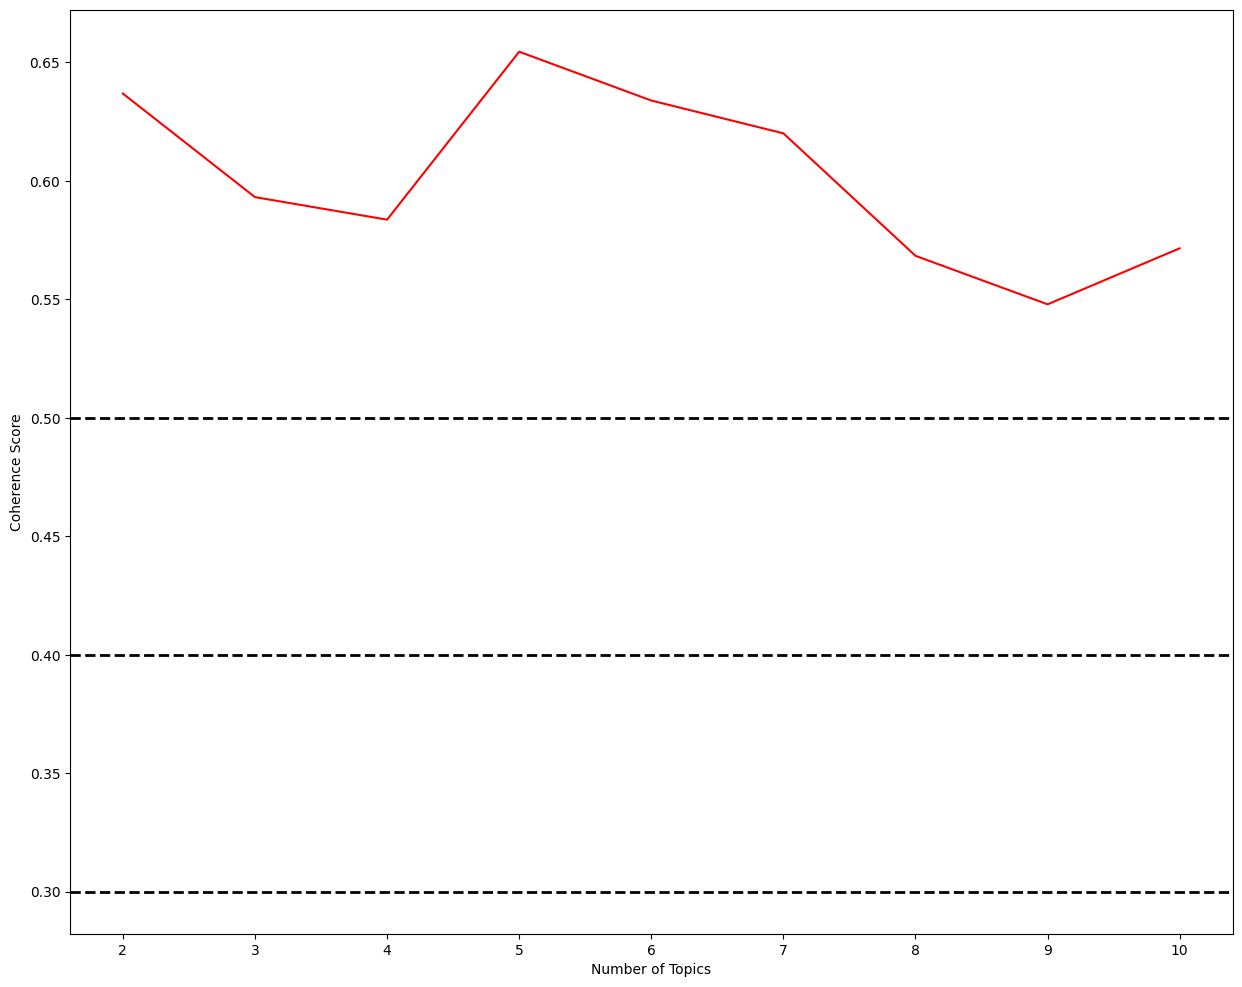

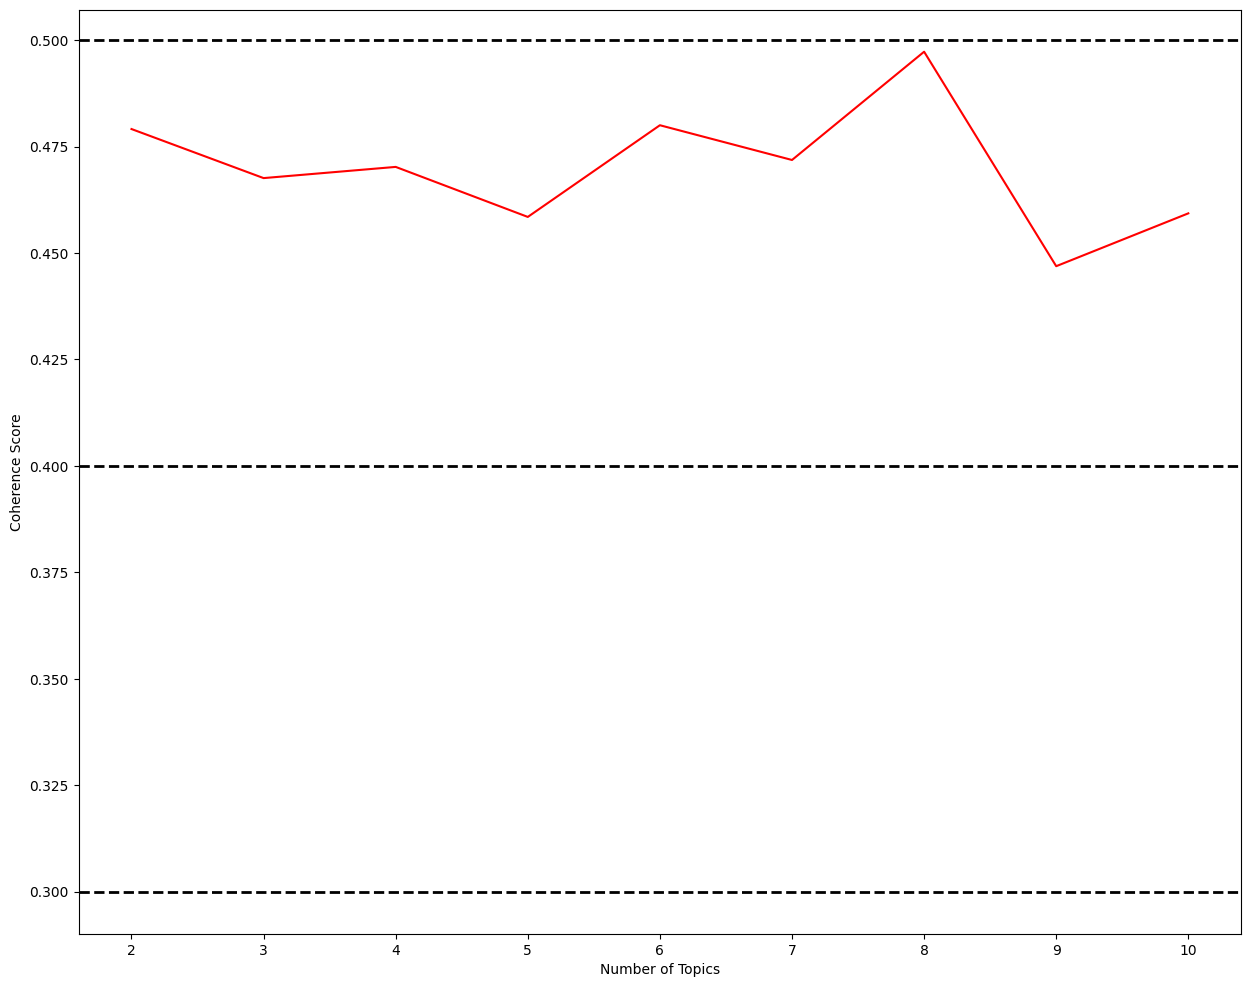

In [10]:
# Calculate coherence scores for each model
target_text = "review_cleaned_v3"

overall_coherence_df = pd.DataFrame() # df to store coherence_df
model_topic_info_list = []  # List to store model_topic_info

for i, df_set in enumerate(df_sets):
    
    print("\nDF NAME: {}\n".format(df_names[i]))

    coherence_df, model_topic_info = topic_model_coherence_plot(df_set, df_names[i], target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT)
    overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0) # Concatenate to overall_coherence_df
    model_topic_info_list.append(model_topic_info) # Store model_topic_info in a list

In [11]:
# Print all models' coherence scores
overall_coherence_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,2,0.690705,df_pos
1,LSI,3,0.678271,df_pos
2,LSI,4,0.659121,df_pos
3,LSI,5,0.679874,df_pos
4,LSI,6,0.674328,df_pos
5,LSI,7,0.664552,df_pos
6,LSI,8,0.644246,df_pos
7,LSI,9,0.641189,df_pos
8,LSI,10,0.660286,df_pos
0,LDA,2,0.498530,df_pos


In [12]:
# Store coherence scores of all models into "overall_coherence_df", sort by "df_name" and "Coherence Score"
overall_coherence_df = overall_coherence_df.sort_values(["df_name", "Coherence Score"], ascending=False).reset_index(drop=True)
#overall_coherence_df

# Find best model for each df
overall_coherence_best_df = overall_coherence_df.loc[overall_coherence_df.groupby("df_name")["Coherence Score"].idxmax()].reset_index(drop=True)
overall_coherence_best_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,5,0.654445,df_neg
1,LSI,2,0.690705,df_pos


In [13]:
# Print topics of best model
print_best_model_topics(overall_coherence_best_df, model_topic_info_list)


DF NAME: df_neg
MODEL: LSI - NUMBER OF TOPICS: 5

Topic 1: service, breakfast, toilet, water, shower, dirty, bathroom, change, work, smell

Topic 2: breakfast, toilet, smell, dirty, water, service, restaurant, shower, tell, wait

Topic 3: service, change, dirty, toilet, water, breakfast, shower, request, housekeep, look

Topic 4: water, dirty, wait, breakfast, open, card, service, key, mind, first

Topic 5: water, smell, breakfast, service, dirty, wait, mind, tell, old, work

----------


DF NAME: df_pos
MODEL: LSI - NUMBER OF TOPICS: 2

Topic 1: great, friendly, station, singapore, food, really, breakfast, helpful, overall, close

Topic 2: great, station, water, provide, request, bathroom, use, however, change, towel

----------



In [14]:
end_time = datetime.now()
print("Text processing ended at {}".format(end_time))
print("Text processing spent {}".format(end_time - start_time))

Text processing ended at 2024-06-27 00:36:48.311544
Text processing spent 0:21:21.858451
